In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
import string

In [3]:
post = pd.read_json('posts.json') #Using post shared
post

,timestamp,data,title,attachments,tags
0,2014-07-13 09:44:45,[{}],"Shivang Naik recommends YOUTH CLUB, PUNI.",NaN,NaN
1,2014-07-17 14:27:10,[],Shivang Naik added a new photo.,[{'data': [{'media': {'uri': 'posts/media/Mobi...,NaN
2,2014-07-27 06:46:39,"[{'post': 'chal chodu i beat your score'}, {}]",Shivang Naik posted something via Candy Crush ...,[{'data': [{'external_context': {'name': 'Mohi...,NaN
3,2014-08-12 12:34:25,[{}],NaN,NaN,NaN
4,2014-08-12 12:34:28,[{}],NaN,NaN,NaN
...,...,...,...,...,...
511,2019-10-18 06:56:52,"[{'post': 'Happy Birthday ð¥³'}, {}]",Shivang Naik wrote on Avani Chauhan Medhat's T...,NaN,NaN
512,2019-10-20 04:55:49,"[{'post': 'Happy Birthday ð¥³'}, {}]",Shivang Naik wrote on Shivangi Harshal Mehta's...,NaN,NaN
513,2019-10-20 04:56:02,"[{'post': 'Happy Birthday ð¥³'}, {}]",Shivang Naik wrote on Shweta Naik's Timeline.,NaN,NaN
514,2019-12-02 03:21:32,"[{'post': 'Happy Birthday ð¥³'}, {}]",Shivang Naik wrote on Punit Naik's Timeline.,NaN,NaN


# Data Cleaning

In [4]:
#Converting Timestamp into 'Date' and 'Time' columns
post['Date1'] = post['timestamp'].dt.date
post['Time1'] = post['timestamp'].dt.time
# Insert 'Date' column at index 1
post.insert(1, 'Date', post['Date1'])

# Insert 'Time' column at index 2
post.insert(2, 'Time', post['Time1'])

post=post.drop(['timestamp','Date1','Time1'],axis=1)

In [5]:
# Getting comments of Post in 'posts'
posts = []

column_values = post['data']

for value in column_values:
    if isinstance(value, list) and len(value) > 0:
        if 'post' in value[0]:
            posts.append(value[0]['post'])
        else:
            posts.append('None')
    else:
        posts.append('None')

In [6]:
#Getting different tag person name in 'names'
names = []

column_values = post['tags']

for value in column_values:
    if isinstance(value, str):
        names.append('None')
    elif isinstance(value, list):
        name_list = [item['name'] for item in value if isinstance(item, dict) and 'name' in item]
        if len(name_list) > 0:
            names.append(', '.join(name_list))
        else:
            names.append('None')
    else:
        names.append('None')

In [7]:
#Creating new dataframe
new_df = post.copy()
new_df = new_df.drop(['data','attachments','tags'],axis=1) #Dropping columns
#Adding 'names' and 'posts' to new dataframe
new_df['tags'] = names
new_df['data'] = posts
new_df

,Date,Time,title,tags,data
0,2014-07-13,09:44:45,"Shivang Naik recommends YOUTH CLUB, PUNI.",None,None
1,2014-07-17,14:27:10,Shivang Naik added a new photo.,None,None
2,2014-07-27,06:46:39,Shivang Naik posted something via Candy Crush ...,None,chal chodu i beat your score
3,2014-08-12,12:34:25,NaN,None,None
4,2014-08-12,12:34:28,NaN,None,None
...,...,...,...,...,...
511,2019-10-18,06:56:52,Shivang Naik wrote on Avani Chauhan Medhat's T...,None,Happy Birthday ð¥³
512,2019-10-20,04:55:49,Shivang Naik wrote on Shivangi Harshal Mehta's...,None,Happy Birthday ð¥³
513,2019-10-20,04:56:02,Shivang Naik wrote on Shweta Naik's Timeline.,None,Happy Birthday ð¥³
514,2019-12-02,03:21:32,Shivang Naik wrote on Punit Naik's Timeline.,None,Happy Birthday ð¥³


In [8]:
#Cleaning post['atatchments']
data = post['attachments'].tolist()
df = post.copy()

# Define column names for the desired data
#Column names are choosen based on post['attachments'] data and particular data is chosen
#here 'media_title' is used for how post is upload 
#'media_description' is used for description with post, 
#'external_source_name'is used for title of some external post, 
#'life_event_text' is used for title of live event hared,
#'other_text' is used for other random comments


columns = ['media_title', 'media_description', 'external_source_name', 'life_event_text', 'other_text']
# Initialize an empty DataFrame with empty strings
df = pd.DataFrame('', index=range(len(data)), columns=columns)

# Iterate over the data list and extract the relevant information
for i, item in enumerate(data):
    if item and isinstance(item, list):
        for element in item:
            if isinstance(element, dict):
                for key, value in element.items():
                    if key == 'data' and isinstance(value, list):
                        for sub_element in value:
                            if isinstance(sub_element, dict):
                                if 'media' in sub_element:
                                    media_title = sub_element['media'].get('title', '')
                                    media_description = sub_element['media'].get('description', '')
                                    df.at[i, 'media_title'] = media_title
                                    df.at[i, 'media_description'] = media_description
                                elif 'external_context' in sub_element:
                                    external_source_name = sub_element['external_context'].get('name', '')
                                    df.at[i, 'external_source_name'] = external_source_name
                                elif 'life_event' in sub_element:
                                    life_event_text = sub_element['life_event'].get('title', '')
                                    df.at[i, 'life_event_text'] = life_event_text
                                elif 'text' in sub_element:
                                    other_text = sub_element['text']
                                    df.at[i, 'other_text'] = other_text

# Display the resulting DataFrame
df

,media_title,media_description,external_source_name,life_event_text,other_text
0,,,,,
1,Mobile uploads,,,,
2,,,"Mohit, I beat your score at level 4!",,
3,,,,,
4,,,,,
...,...,...,...,...,...
511,,,,,
512,,,,,
513,,,,,
514,,,,,


In [9]:
#Joining two dataframes and replacing '' and 'NaN' with 'None' values

df1 = new_df.join(df)
df1 = df1.replace('', 'None')
df1 = df1.replace(np.nan, 'None')
df1

,Date,Time,title,tags,data,media_title,media_description,external_source_name,life_event_text,other_text
0,2014-07-13,09:44:45,"Shivang Naik recommends YOUTH CLUB, PUNI.",None,None,None,None,None,None,None
1,2014-07-17,14:27:10,Shivang Naik added a new photo.,None,None,Mobile uploads,None,None,None,None
2,2014-07-27,06:46:39,Shivang Naik posted something via Candy Crush ...,None,chal chodu i beat your score,None,None,"Mohit, I beat your score at level 4!",None,None
3,2014-08-12,12:34:25,None,None,None,None,None,None,None,None
4,2014-08-12,12:34:28,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...
511,2019-10-18,06:56:52,Shivang Naik wrote on Avani Chauhan Medhat's T...,None,Happy Birthday ð¥³,None,None,None,None,None
512,2019-10-20,04:55:49,Shivang Naik wrote on Shivangi Harshal Mehta's...,None,Happy Birthday ð¥³,None,None,None,None,None
513,2019-10-20,04:56:02,Shivang Naik wrote on Shweta Naik's Timeline.,None,Happy Birthday ð¥³,None,None,None,None,None
514,2019-12-02,03:21:32,Shivang Naik wrote on Punit Naik's Timeline.,None,Happy Birthday ð¥³,None,None,None,None,None


In [10]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 516 entries, 0 to 515
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Date                  516 non-null    object
 1   Time                  516 non-null    object
 2   title                 516 non-null    object
 3   tags                  516 non-null    object
 4   data                  516 non-null    object
 5   media_title           516 non-null    object
 6   media_description     516 non-null    object
 7   external_source_name  516 non-null    object
 8   life_event_text       516 non-null    object
 9   other_text            516 non-null    object
dtypes: object(10)
memory usage: 40.4+ KB


# Data Visualization

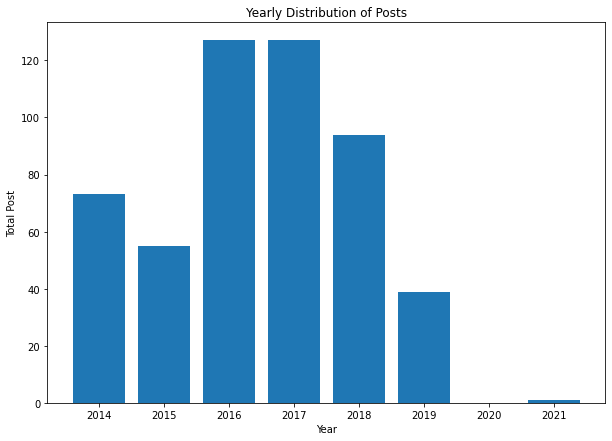

In [11]:
# Extract the year from the 'Date' column
df1['Date'] = pd.to_datetime(df1['Date'])
df3 = pd.DataFrame()
df3['Year'] = df1['Date'].dt.year

# Count the occurrences of each year
year_counts = df3['Year'].value_counts()

# Reverse the series to display the largest values at the top
year_counts = year_counts.iloc[::-1]

plt.figure(figsize=(10, 7))
# Plot the horizontal bar chart
plt.bar(year_counts.index, year_counts.values)

# Set the x-axis label
plt.xlabel('Year')

# Set the y-axis label
plt.ylabel('Total Post')

# Set the title of the chart
plt.title('Yearly Distribution of Posts')

# Display the chart
plt.show()

In [12]:
#Yearly Distribution of post where '2016' and '2017' year has same post that is 127 and '2020' has lowest with 0 post.

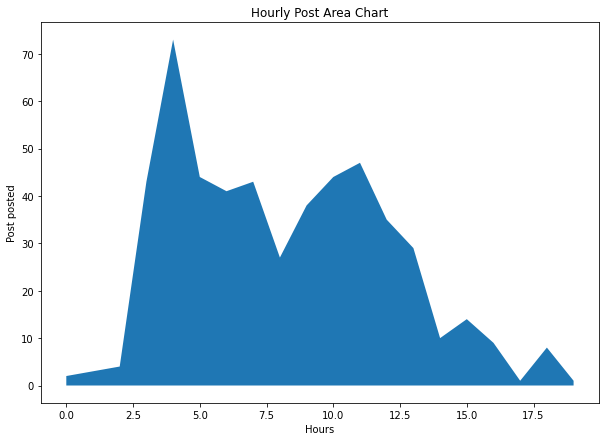

In [13]:
# Extract the year from the 'Date' column

df3['Hour'] = df1['Time'].apply(lambda x: x.hour)

# Count the occurrences of each year
hour_counts = df3['Hour'].value_counts()

# Sort the hour_counts by index (hour values)
hour_counts = hour_counts.sort_index()

plt.figure(figsize=(10, 7))
# Plot the area chart
plt.fill_between(hour_counts.index, hour_counts.values)

# Set the x-axis label
plt.xlabel('Hours')

# Set the y-axis label
plt.ylabel('Post posted')

# Set the title of the chart
plt.title('Hourly Post Area Chart')

# Display the chart
plt.show()

In [14]:
#Morning 4-6 is the busiest time for posting.

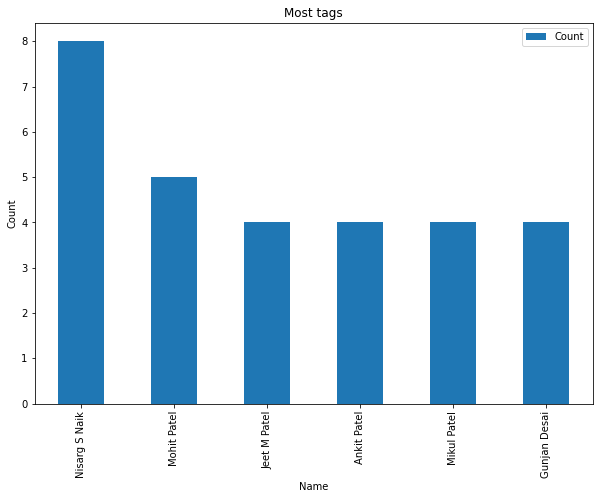

In [15]:
import pandas as pd

# Assuming df1 is your DataFrame containing the 'tags' column

# Create an empty dictionary to store the name counts
name_counts = {}

# Iterate over each row in the 'tags' column
for tags in df1['tags']:
    # Check if the tags value is not None
    if tags != 'None':
        # Split the names by comma and remove any leading/trailing whitespace
        names = [name.strip() for name in tags.split(',')]
        
        # Iterate over each name and update the count in the dictionary
        for name in names:
            name_counts[name] = name_counts.get(name, 0) + 1

# Create a DataFrame from the name counts dictionary
name_counts_df = pd.DataFrame({'Name': list(name_counts.keys()), 'Count': list(name_counts.values())})

#print(name_counts_df)
sorted_df = name_counts_df.sort_values(by='Count', ascending=False)

sorted_df = sorted_df.head(6)

sorted_df.plot(x='Name', y='Count', kind='bar', figsize=(10, 7))

# Set the x-axis label
plt.xlabel('Name')

# Set the y-axis label
plt.ylabel('Count')

# Set the title of the chart
plt.title('Most tags')

# Show the chart
plt.show()

In [16]:
# Most tagged person is 'Nisarg S Naik' with 8 count.

# Data Preprocessing

In [17]:
import re
## Removing punctuation mark, converting to lowercase and stopwords
def text_preprocess(text):
    nopunc = re.sub(r'[^a-zA-Z\s]', '', text)
    nopunc = ''.join(nopunc)
    return ' '.join([word for word in nopunc.split() if word.lower() not in stopwords.words('english') and not word.isdigit()])

In [18]:
lemmatizer = WordNetLemmatizer()

def lemmatize_words(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

In [19]:
df2 = pd.DataFrame(df1['data'], columns=['data'])
df2.data = df2.data.apply(text_preprocess)
df2.data = df2.data.apply(lemmatize_words)

In [20]:
# Creating nltk and vader analyzer 
nltk_analyzer = SentimentIntensityAnalyzer()

# Calculating nltk
def nltk_sentiment(text):
    sentiment_dict = nltk_analyzer.polarity_scores(text)
    return sentiment_dict['neg'], sentiment_dict['neu'], sentiment_dict['pos'], sentiment_dict['compound']

df2[['nltk_negative', 'nltk_neutral', 'nltk_positive', 'nltk_compound']] = df2['data'].apply(nltk_sentiment).apply(pd.Series)

df2

,data,nltk_negative,nltk_neutral,nltk_positive,nltk_compound
0,None,0.0,1.000,0.000,0.0000
1,None,0.0,1.000,0.000,0.0000
2,chal chodu beat score,0.0,1.000,0.000,0.0000
3,None,0.0,1.000,0.000,0.0000
4,None,0.0,1.000,0.000,0.0000
...,...,...,...,...,...
511,Happy Birthday,0.0,0.213,0.787,0.5719
512,Happy Birthday,0.0,0.213,0.787,0.5719
513,Happy Birthday,0.0,0.213,0.787,0.5719
514,Happy Birthday,0.0,0.213,0.787,0.5719


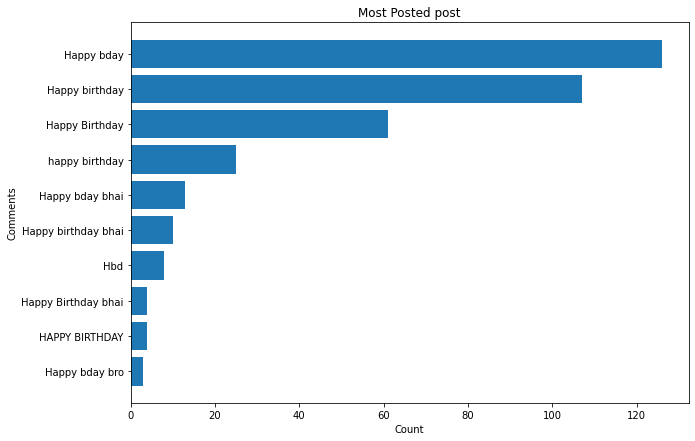

In [21]:
a = df2['data'].value_counts().head(11)
a = a.drop('None')

# Reverse the series to display the largest values at the top
a = a.iloc[::-1]
plt.figure(figsize=(10, 7))
# Plot the horizontal bar chart
plt.barh(a.index, a.values)

# Set the x-axis label
plt.xlabel('Count')

# Set the y-axis label
plt.ylabel('Comments')

# Set the title of the chart
plt.title('Most Posted post')

# Display the chart
plt.show()


In [22]:
#"Happy bday" was highest with 126 count and "Happy birthday" with 107 at second place

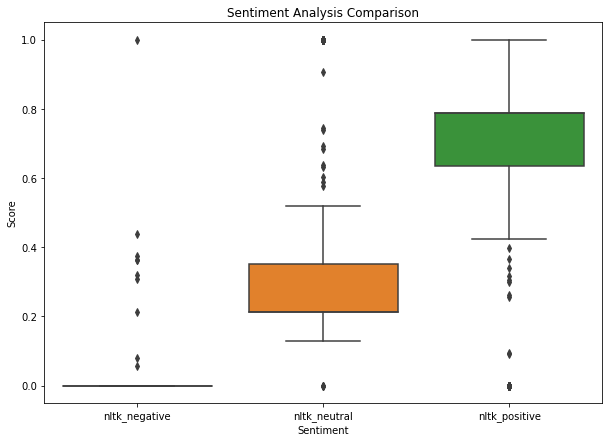

In [23]:
# Extract the sentiment scores for each method
nltk_scores = df2[['nltk_negative', 'nltk_neutral', 'nltk_positive']]

# Reshape the data into long format
nltk_scores = pd.melt(nltk_scores, var_name='Sentiment', value_name='Score')

# Combine the dataframes (if necessary)
combined_scores = nltk_scores

plt.figure(figsize=(10, 7))
sns.boxplot(x='Sentiment', y='Score', data=combined_scores)
plt.xlabel('Sentiment')
plt.ylabel('Score')
plt.title('Sentiment Analysis Comparison')

plt.show()


In [24]:
#Average positive sentiment was between 0.6 and 0.8, 
#Average neutral sentiment was between 0 with few outliers, 
#Average negative sentiment was between 0.2 and 0.4 

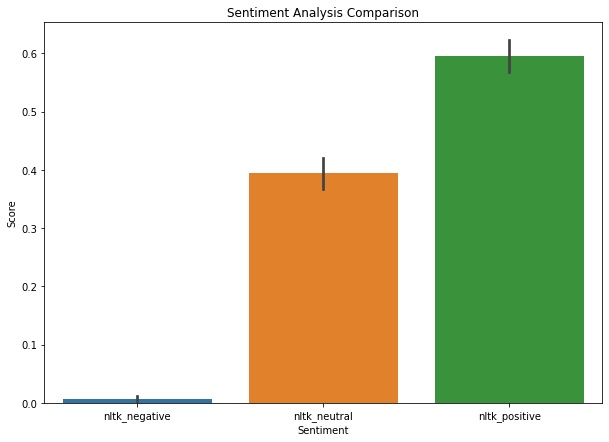

In [25]:
# Extract the sentiment scores for each method
nltk_scores = df2[['nltk_negative', 'nltk_neutral', 'nltk_positive']]

# Reshape the data into long format
nltk_scores = pd.melt(nltk_scores, var_name='Sentiment', value_name='Score')

# Combine the dataframes
combined_scores = pd.concat([nltk_scores])

plt.figure(figsize=(10, 7))
sns.barplot(x='Sentiment', y='Score', data=combined_scores)
plt.xlabel('Sentiment')
plt.ylabel('Score')
plt.title('Sentiment Analysis Comparison')

plt.show()

In [60]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import requests

In [61]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

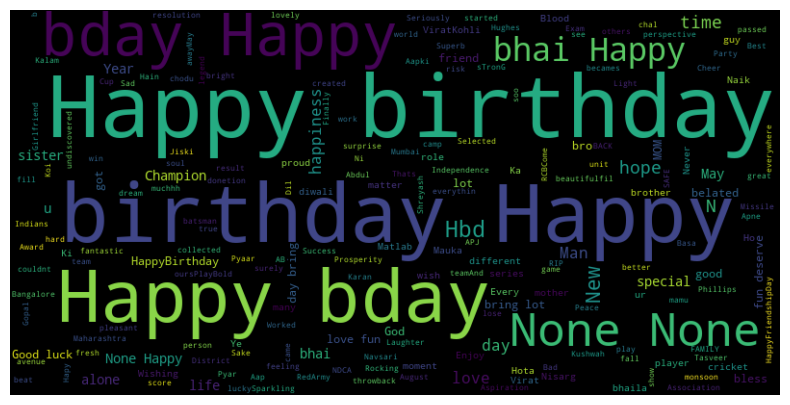

In [62]:
# Create a string of all preprocessed text
all_text = ' '.join(df2['data'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400).generate(all_text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()